<a href="https://colab.research.google.com/github/eliind7/Naturliga_proj/blob/master/network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/archive.zip", 'r')
zip_ref.extractall("/content/dataset")
zip_ref.close()



In [ ]:
animal_dir = "/content/dataset/animals/animals"
len(os.listdir(animal_dir))

90

In [ ]:

with open("/content/dataset/name of the animals.txt", 'r') as f:
    animal_info = f.read()
print(animal_info.split())



['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']


In [ ]:
path = animal_dir

In [ ]:
animal_names = {}
animal_directories = os.listdir(path)

for animal_name in animal_directories:
    animal_path = os.path.join(path, animal_name)
    num_images = len(os.listdir(animal_path))
    animal_names[animal_name] = num_images

print(animal_names)

{'whale': 60, 'badger': 60, 'kangaroo': 60, 'snake': 60, 'squid': 60, 'sparrow': 60, 'rat': 60, 'goldfish': 60, 'turkey': 60, 'hamster': 60, 'parrot': 60, 'butterfly': 60, 'fly': 60, 'ladybugs': 60, 'pelecaniformes': 60, 'porcupine': 60, 'beetle': 60, 'mouse': 60, 'sandpiper': 60, 'crow': 60, 'wombat': 60, 'oyster': 60, 'seahorse': 60, 'sheep': 60, 'dolphin': 60, 'crab': 60, 'cow': 60, 'orangutan': 60, 'caterpillar': 60, 'gorilla': 60, 'goat': 60, 'goose': 60, 'fox': 60, 'swan': 60, 'hippopotamus': 60, 'grasshopper': 60, 'lion': 60, 'hummingbird': 60, 'bat': 60, 'hyena': 60, 'horse': 60, 'seal': 60, 'coyote': 60, 'hare': 60, 'pig': 60, 'dragonfly': 60, 'chimpanzee': 60, 'squirrel': 60, 'moth': 60, 'possum': 60, 'boar': 60, 'hornbill': 60, 'panda': 60, 'okapi': 60, 'starfish': 60, 'bear': 60, 'lizard': 60, 'zebra': 60, 'eagle': 60, 'deer': 60, 'hedgehog': 60, 'reindeer': 60, 'lobster': 60, 'raccoon': 60, 'tiger': 60, 'otter': 60, 'octopus': 60, 'donkey': 60, 'rhinoceros': 60, 'dog': 60,

In [ ]:
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from PIL import Image
import torch
from torchvision import transforms
from collections import Counter


import os
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa
import numpy as np
from PIL import Image

import os
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa
import numpy as np
from PIL import Image

def load_images_labels(path, split_ratio=0.7):
    classes = os.listdir(path)
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
    all_images = []
    all_labels = []

    for folder in classes:
        anim_fold = os.path.join(path, folder)
        folder_images = [os.path.join(anim_fold, img) for img in os.listdir(anim_fold)]
        all_images.extend(folder_images)
        all_labels.extend([class_to_idx[folder]] * len(folder_images))

    train_images, test_images, train_labels, test_labels = train_test_split(
        all_images, all_labels, test_size=(1 - split_ratio), stratify=all_labels)

    return train_images, train_labels, test_images, test_labels, class_to_idx


from sklearn.model_selection import train_test_split
from collections import defaultdict

def balanced_class_split(images, labels, split_ratio=0.5):
    # Count the number of samples for each class
    class_counts = defaultdict(int)
    for label in labels:
        class_counts[label] += 1

    # Determine the number of samples to include from each class in each split
    class_sample_counts = {cls: int(count * split_ratio) for cls, count in class_counts.items()}

    test_images = []
    test_labels = []
    validation_images = []
    validation_labels = []

    # Split the training set into two subsets with balanced class distribution
    for img, label in zip(images, labels):
        if class_sample_counts[label] > 0:
            test_images.append(img)
            test_labels.append(label)
            class_sample_counts[label] -= 1
        else:
            validation_images.append(img)
            validation_labels.append(label)

    return (test_images, test_labels), (validation_images, validation_labels)

def minmax_scale(x):
    return (x - x.min()) / (x.max() - x.min())


class DatasetNew(Dataset):
    def __init__(self, images, labels, class_to_idx):
        super().__init__()
        self.transforms = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: minmax_scale(x)),
        ])
        self.images = images
        self.labels = labels
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        return self.transforms(img), torch.tensor(label, dtype=torch.long)

    def get_class_labels(self):
        return self.class_to_idx

    def class_distribution(self):
        images = self.images
        labels = self.labels

        class_counts = Counter(labels)
        print(f"Class distribution in  dataset:")
        for cls, count in class_counts.items():
            print(f"Class {cls}: {count} samples")


## Network code


In [ ]:
%matplotlib inline

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [ ]:
data_idx = 1  # Example index, ensure this is used correctly or remove if not needed

train_images, train_labels, test_validation_images, test_validation_labels, class_to_idx  = load_images_labels(path=path)
(test_images, test_labels), (validation_images, validation_labels) = balanced_class_split(test_validation_images, test_validation_labels)



# Create dataset instances
train_dataset = DatasetNew(train_images,train_labels, class_to_idx)
test_dataset = DatasetNew(test_images,test_labels, class_to_idx)
validation_dataset = DatasetNew(validation_images,validation_labels, class_to_idx)

batch_size = 4

print("Training data length:", len(train_dataset))
print("Testing data length:", len(test_dataset))
print("Testing data length:", len(validation_dataset))

# Create DataLoaders
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
validationloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


Training data length: 3779
Testing data length: 810
Testing data length: 811


In [ ]:
classes = train_dataset.get_class_labels()
print(classes)

#train_dataset.class_distribution()
#test_dataset.class_distribution()
#validation_dataset.class_distribution()



{'dog': 0, 'okapi': 1, 'beetle': 2, 'hedgehog': 3, 'hornbill': 4, 'hippopotamus': 5, 'possum': 6, 'rat': 7, 'lizard': 8, 'woodpecker': 9, 'cat': 10, 'moth': 11, 'horse': 12, 'jellyfish': 13, 'donkey': 14, 'fly': 15, 'hummingbird': 16, 'wolf': 17, 'turkey': 18, 'mosquito': 19, 'shark': 20, 'dragonfly': 21, 'sheep': 22, 'goose': 23, 'panda': 24, 'reindeer': 25, 'cow': 26, 'goldfish': 27, 'cockroach': 28, 'deer': 29, 'wombat': 30, 'whale': 31, 'coyote': 32, 'snake': 33, 'elephant': 34, 'caterpillar': 35, 'fox': 36, 'squirrel': 37, 'oyster': 38, 'lobster': 39, 'pig': 40, 'penguin': 41, 'parrot': 42, 'ox': 43, 'rhinoceros': 44, 'dolphin': 45, 'zebra': 46, 'antelope': 47, 'lion': 48, 'hamster': 49, 'octopus': 50, 'badger': 51, 'raccoon': 52, 'swan': 53, 'leopard': 54, 'crab': 55, 'pelecaniformes': 56, 'boar': 57, 'ladybugs': 58, 'flamingo': 59, 'sandpiper': 60, 'hare': 61, 'starfish': 62, 'orangutan': 63, 'mouse': 64, 'tiger': 65, 'bee': 66, 'hyena': 67, 'bison': 68, 'grasshopper': 69, 'seah

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


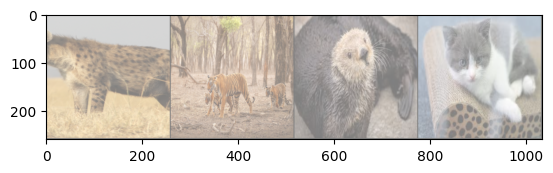

Labels and corresponding files:
Label: hyena
Label: tiger
Label: otter
Label: cat


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels and corresponding files
print('Labels and corresponding files:')
for i in range(batch_size):
    # Retrieve the file path and label using the batch index
    idx = labels[i].item()  # Get the original index if label is a tensor
    class_name = {v: k for k, v in train_dataset.class_to_idx.items()}[idx]  # Reverse mapping from index to class name
    image_path = train_dataset.images[i]  # This assumes the dataset images list is ordered as per DataLoader (might need adjustment)
    print(f'Label: {class_name}')


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.relu = nn.ReLU()

        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fourth convolutional block
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 16 * 16, 512)  # Adjust this size based on your input image dimensions
        self.bn5 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 90)  # Output layer for 90 classes
        self.bn6 = nn.BatchNorm1d(90)

    def forward(self, x):
        # Apply first convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)

        # Apply second convolutional block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)

        # Apply third convolutional block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool3(x)

        # Apply fourth convolutional block
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.pool4(x)

        # Flatten and apply fully connected layers
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.fc2(x)
        output = self.bn6(x)

        return output

import torch.nn as nn
import torch.nn.functional as F

class Net_64(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.relu = nn.ReLU()

        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fourth convolutional block
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 4 * 4, 512)  # Adjusted based on 64x64 input size
        self.bn5 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 90)  # Output layer for 90 classes
        self.bn6 = nn.BatchNorm1d(90)

    def forward(self, x):
        # Apply first convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)

        # Apply second convolutional block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)

        # Apply third convolutional block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool3(x)

        # Apply fourth convolutional block
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.pool4(x)

        # Flatten and apply fully connected layers
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.fc2(x)
        output = self.bn6(x)

        return output


In [ ]:
net = Net()
net.to(device)

Net(
  (relu): ReLU()
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, paddin

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [ ]:
import torch

best_loss = float('inf')  # Initialize the best loss to infinity
patience = 6  # Number of epochs to wait if validation loss doesn't improve
wait_count = 0  # Initialize the wait count
max_epochs = 50  # Maximum number of epochs
#epochs = []
epoch_running_loss = 0;
#epoch_loss = [];
#validation_loss = [];

for epoch in range(max_epochs):  # loop over the dataset multiple times
    running_loss = 0.0

    # Training phase
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # add current loss
        running_loss += loss.item()

        # print statistics
        if i % 50 == 49:  # print every 50 mini-batches
            epoch_running_loss += running_loss
            average_loss = running_loss / 50
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {average_loss:.3f}')
            running_loss = 0.0
    epoch_running_loss = epoch_running_loss / i
    print(f"epoch {epoch} average loss; {epoch_running_loss}")
    epoch_loss.append(epoch_running_loss)
    epoch_running_loss = 0
    epochs.append(epoch)
    with torch.no_grad():
        val_loss = 0.0
        for validation_data in validationloader:
          images, labels = validation_data
          # calculate outputs by running images through the network
          outputs = net(images.to(device))
          val_loss += criterion(outputs, labels.to(device)).item()
        val_loss /= len(validationloader)
        print(f'Validation loss: {val_loss:.3f}')
        print(f'best loss: {best_loss:.3f}')
        validation_loss.append(val_loss)

        # Check if validation loss has improved
        if val_loss < best_loss:
            best_loss = val_loss
            wait_count = 0  # Reset the wait count
            torch.save(net.state_dict(), 'best_net.pth')
        else:
            print("val loss larger than best loss")
            wait_count += 1

        if wait_count >= patience:
            print(f'Early stopping at epoch {epoch + 1}. Best loss: {best_loss:.3f}')
            break

print(f'Finished Training. Best loss: {best_loss:.3f}')


[1,    50] loss: 1.470
[1,   100] loss: 1.421
[1,   150] loss: 1.422
[1,   200] loss: 1.451
[1,   250] loss: 1.525
[1,   300] loss: 1.467
[1,   350] loss: 1.454
[1,   400] loss: 1.423
[1,   450] loss: 1.478
[1,   500] loss: 1.478
[1,   550] loss: 1.431
[1,   600] loss: 1.493
[1,   650] loss: 1.429
[1,   700] loss: 1.465
[1,   750] loss: 1.486
[1,   800] loss: 1.409
[1,   850] loss: 1.406
[1,   900] loss: 1.400
epoch 0 average loss; 1.3829211595199875
Validation loss: 3.661
best loss: inf
[2,    50] loss: 1.448
[2,   100] loss: 1.400
[2,   150] loss: 1.436
[2,   200] loss: 1.409
[2,   250] loss: 1.410
[2,   300] loss: 1.453
[2,   350] loss: 1.379
[2,   400] loss: 1.435
[2,   450] loss: 1.386
[2,   500] loss: 1.423
[2,   550] loss: 1.417
[2,   600] loss: 1.395
[2,   650] loss: 1.392
[2,   700] loss: 1.420
[2,   750] loss: 1.355
[2,   800] loss: 1.381
[2,   850] loss: 1.404
[2,   900] loss: 1.525
epoch 1 average loss; 1.3488999978970673
Validation loss: 3.711
best loss: 3.661
val loss lar

In [ ]:
print(epochs)
epochs = list(range(len(validation_loss)))
print(epochs)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


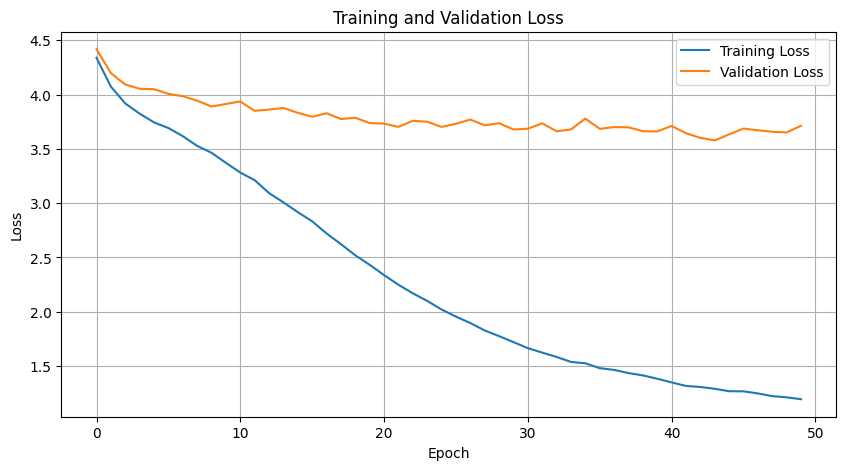

In [ ]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, epoch_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("errors.png")
plt.show()

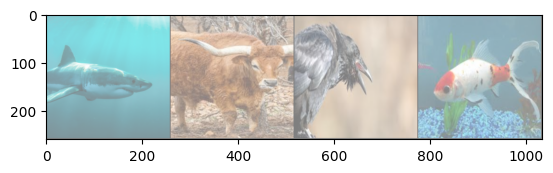

tensor([20, 43, 74, 27])


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print(labels)

In [ ]:
outputs = net(images.to(device))

In [ ]:
_, predicted = torch.max(outputs, 1)

print(predicted)

print(outputs.shape)

tensor([49, 43, 53, 27], device='cuda:0')
torch.Size([4, 90])


In [ ]:
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 26 %


In [ ]:
# prepare to count predictions for each class
print("classes", classes)
correct_pred = {classname: 0 for classname in classes}
keys = list(classes.keys())
print(keys)
total_pred = {classname: 0 for classname in classes}

n = 90  # Adjust this number based on how many items you need
amount_pred = {i: 0 for i in range(n)}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # Move data to the correct device
        outputs = net(images)

        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            label_item = label.item()  # Convert label tensor to a Python int
            prediction_item = prediction.item()  # Convert prediction tensor to a Python int
            amount_pred[prediction_item] += 1
            class_name = keys[label_item]  # Use the int as key to lookup class name
            if label_item == prediction_item:
                correct_pred[class_name] += 1
            total_pred[class_name] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

print(amount_pred)


classes {'bee': 0, 'otter': 1, 'grasshopper': 2, 'lion': 3, 'donkey': 4, 'ladybugs': 5, 'pig': 6, 'woodpecker': 7, 'antelope': 8, 'flamingo': 9, 'hare': 10, 'mosquito': 11, 'koala': 12, 'boar': 13, 'fly': 14, 'dolphin': 15, 'lobster': 16, 'sandpiper': 17, 'cat': 18, 'goldfish': 19, 'cow': 20, 'rhinoceros': 21, 'hornbill': 22, 'jellyfish': 23, 'tiger': 24, 'penguin': 25, 'possum': 26, 'duck': 27, 'caterpillar': 28, 'moth': 29, 'swan': 30, 'okapi': 31, 'lizard': 32, 'bison': 33, 'bat': 34, 'goat': 35, 'bear': 36, 'badger': 37, 'wolf': 38, 'oyster': 39, 'turkey': 40, 'cockroach': 41, 'dog': 42, 'butterfly': 43, 'leopard': 44, 'sheep': 45, 'coyote': 46, 'raccoon': 47, 'crow': 48, 'dragonfly': 49, 'gorilla': 50, 'starfish': 51, 'deer': 52, 'pigeon': 53, 'reindeer': 54, 'owl': 55, 'snake': 56, 'hamster': 57, 'ox': 58, 'horse': 59, 'beetle': 60, 'whale': 61, 'panda': 62, 'hippopotamus': 63, 'turtle': 64, 'goose': 65, 'mouse': 66, 'seahorse': 67, 'sparrow': 68, 'zebra': 69, 'fox': 70, 'octopus